# UAVSAR

```{admonition} Learning Objectives
*A 15 minute guide to UAVSAR data for SnowEX*
- overview of UAVSAR data (both InSAR and PolSAR products)
- demonstrate how to access and transform data
- use Python rasterio and matlotlib
```

```{figure} ../../img/UAVSAR_plane.jpg
---
height: 400px
name: UAVSAR
---
## Picture of UAVSAR. [Source](https://asf.alaska.edu/data-sets/sar-data-sets/uavsar/)
```


Intro slide deck: https://uavsar.jpl.nasa.gov/education/what-is-uavsar.html 

In [1]:
# import libraries
import re
import zipfile
import getpass
from osgeo import gdal 
import os  # for chdir, getcwd, path.basename, path.exists
import hvplot.xarray
import pandas as pd # for DatetimeIndex 
import rioxarray
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data
import codecs # for text parsing code
import glob # for listing files in tiff conversion function
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx

#from osgeo import gdal # for GetRasterBand, Open, ReadAsArray
#import matplotlib
#import matplotlib.pylab as plb # for add_patch, add_subplot, figure, hist, imshow, set_title, xaxis,_label, text 
#import matplotlib.patches as patches  # for Rectangle
#import matplotlib.animation as an # for FuncAnimation
#import subprocess

## What is UAVSAR?

UAVSAR stands for uninhabited aerial vehicle synthetic apeterature radar. It is a suborbital (airplane) remote sensing instrument operated out of NASA JPL.

| frequency | resolution (rng x azi m) | swath width (km) |
| - | - | - | 
| L-band (23 cm) | 1.8 (5.5? need clariity here) | 16 | 

Documentation:
* https://uavsar.jpl.nasa.gov/education/what-is-uavsar.html
* https://asf.alaska.edu/data-sets/sar-data-sets/uavsar/
* https://ieeexplore-ieee-org.unr.idm.oclc.org/document/1631770 (Rosen et al. 2006)

## NASA SnowEx 2020 and 2021 UAVSAR Campaings

During the winter of 2020 and 2021, NASA conducted an L-band InSAR timeseris at a seris of sites across the Western US with the goal of tracking changes in SWE. Get site coordinate from HP to make map!!!!

```{figure} ../../img/SnowEx2020.png
---
height: 400px
name: UAVSAR map
---
##Map of the UAVSAR flight locations for NASA SnowEx. [Source](Chris Hiemstra)
```


## Data Access

There are multiple ways to access UAVSAR data. Also the SQL database.

* [Alaska Satellite Facility Vertex Portal](https://search.asf.alaska.edu/#/?dataset=UAVSAR)
* [NASA Earthdata Suborbital Search](https://search.earthdata.nasa.gov/portal/suborbital/search?fi=UAVSAR&as[instrument][0]=UAVSAR)
* [JPL UAVSAR Data Search](https://uavsar.jpl.nasa.gov/cgi-bin/data.pl)

https://www.reviewjournal.com/local/lake-mead-projected-to-match-lowest-water-level-in-history-this-week-2373770/## Data Types



```{admonition} InSAR Data Types
:class: InSAR Data Types
- ANN file (.ann): a text annotation file with metadata
- AMP files (.amp1 and .amp2): calibrated multi-looked amplitude products
- INT files (.int): interferogram product, complex number format (we won't be using these here)
- COR files (.cor): interferometric correlation product, a measure of the noise level of the phase
- GRD files (.grd): interferometric products projected to the ground in simple geographic coordinates (latitude, longitude)
- HGT file  (.hgt): the DEM that was used in the InSAR processing
- KML and KMZ files (.kml or .kmz): format for viewing files in Google Earth (can't be used for analysis)
```

```{admonition} PolSAR Data Types
:class: PolSAR Data Types
-
```

In [2]:
# directory in which the notebook resides
if 'tutorial_home_dir' not in globals():
     tutorial_home_dir = os.getcwd()
print("Notebook directory: ", tutorial_home_dir)

if not os.path.exists('/tmp/'):
    os.chdir('/tmp')
   
# directory for data downloads

data_dir = os.path.join('/tmp')
os.makedirs(data_dir, exist_ok=True)
print(data_dir)

Notebook directory:  /home/jovyan/website/book/tutorials/sar
/tmp


## 
Here will use our NASA EarthData to directly download an InSAR pair into our notebook from the ASF wesbite

In [25]:
# Update this with YOUR NASA Earthdata login to download SLC data
ASF_USER = input("Enter Username: ")
ASF_PASS = getpass.getpass("Enter Password: ")

files = ['https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/grmesa_27416_20003-028_20005-007_0011d_s01_L090_01_int_grd.zip',
        'https://datapool.asf.alaska.edu/AMPLITUDE_GRD/UA/grmesa_27416_20003-028_20005-007_0011d_s01_L090_01_amp_grd.zip']
         
if len(ASF_USER)==0 or len(ASF_PASS)==0:
    raise Exception("Specifiy your ASF password and user (earthdata log-in)")
    
for file in files:
    filename = os.path.basename(file)
    
    if not os.path.exists(os.path.join(data_dir,filename)):
        cmd = "wget {0} --user={1} --password={2} -P {3} -nc".format(file, ASF_USER, ASF_PASS, data_dir)
        print(f"Downloading: {file}")
        os.system(cmd)
    else:
        print(filename + " already exists. Skipping download ..")
print("done")
        

Enter Username:  jacktarricone
Enter Password:  ············


Downloading: https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/grmesa_27416_20003-028_20005-007_0011d_s01_L090_01_int_grd.zip
Downloading: https://datapool.asf.alaska.edu/AMPLITUDE_GRD/UA/grmesa_27416_20003-028_20005-007_0011d_s01_L090_01_amp_grd.zip
done


In [26]:
# check to see if downloaded
# the *.* syntax means print all files in the directory
print(glob.glob("/tmp/*.*"))

['/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090_01_int_grd.zip', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090_01_amp_grd.zip']


In [27]:
#use for deleting contents of temp directory if needed

#files = glob.glob("/tmp/*.*")

#for f in files:
#    os.remove(f)

## Unzipping the files we just downloaded

In [28]:
## unzip files just downloaded, this is broken and is looping over and filling up the memory

# define file path
int_zip = '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090_01_int_grd.zip'
amp_zip = '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090_01_amp_grd.zip'

In [29]:
# unzip

# int
with zipfile.ZipFile(int_zip, "r") as zip_ref:
    zip_ref.printdir()
    print('Extracting all the files now...')
    zip_ref.extractall('/tmp')
    print("done")
    
# amp
with zipfile.ZipFile(amp_zip, "r") as zip_ref:
    zip_ref.printdir()
    print('Extracting all the files now...')
    zip_ref.extractall('/tmp')
    print("done")

File Name                                             Modified             Size
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd 2020-04-18 06:21:56    133771008
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd 2020-04-18 06:25:52    133771008
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.int.grd 2020-04-18 06:25:58    267542016
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd 2020-04-18 06:26:10    133771008
grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.cor.grd 2020-04-18 06:26:16    133771008
grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.hgt.grd 2020-04-18 06:26:22    133771008
grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.int.grd 2020-04-18 06:26:30    267542016
grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.unw.grd 2020-04-18 06:26:42    133771008
grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.cor.grd 2020-04-18 06:26:48    133771008
grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.hgt.grd 2020-04-18 06

## Removing unwanted data
For simplicity, we'll only work with HH polarization. The three other polarizations (VV, VH, HV) provide additional information about the surface properties and can be utilized in further analysis.

In [32]:
# clean up unwanted data from what we just downloaded

directory = '/tmp'
os.chdir(directory)
HV_files = glob.glob('*HV_01*')
VV_files = glob.glob('*VV_01*')
VH_files = glob.glob('*VH_01*')
zips = glob.glob('*.zip')

for f in HV_files:
    os.remove(f)
    
for f in VV_files:
    os.remove(f)
    
for f in VH_files:
    os.remove(f)
    
for f in zips:
    os.remove(f)

In [33]:
# check to see what files are left in the directory
print(glob.glob("/tmp/*.*"))

['/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.int.grd', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.ann', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd']


##
Now we only have the HH polarization, the annoation file, and the 6 .grd files!

## Converting Data to GeoTiffs

The downloadable UAVSAR data comes in a flat binary format (.grd), which is not readable by GDAL. Therefore it needs to be transformed for use in standard spatial analysis software (ArcGIS, QGIS, Python, R, MATLAB, etc.) To do this, we will use the uavsar_tiff_convert function, which takes information (latitude, longitude, number of lines and samples, data type, pixel size) from the annotation file to create an ENVI header (.hdr). Once the ENVI header is created, the files can be read into Python and converted to GeoTiffs.

In [34]:
# folder is path to a folder with an .ann (or .txt) and .grd files (.amp1, .amp2, .cor, .unw, .int)

def uavsar_tiff_convert(folder):
    """
    Builds a header file for the input UAVSAR .grd file,
    allowing the data to be read as a raster dataset.
    :param folder:   the folder containing the UAVSAR .grd and .ann files
    """

    os.chdir(folder)
    int_file = glob.glob(os.path.join(folder, 'int.grd'))

    # Empty lists to put information that will be recalled later.
    Lines_list = []
    Samples_list = []
    Latitude_list = []
    Longitude_list = []
    Files_list = []

    # Step 1: Look through folder and determine how many different flights there are
    # by looking at the HDR files.
    for files in os.listdir(folder):
        if files [-4:] == ".grd":
            newfile = open(files[0:-4] + ".hdr", 'w')
            newfile.write("""ENVI
description = {DESCFIELD}
samples = NSAMP
lines = NLINE
bands = 1
header offset = 0
data type = DATTYPE
interleave = bsq
sensor type = UAVSAR L-Band
byte order = 0
map info = {Geographic Lat/Lon, 
            1.000, 
            1.000, 
            LON, 
            LAT,  
            0.0000555600000000, 
            0.0000555600000000, 
            WGS-84, units=Degrees}
wavelength units = Unknown
                """
                          )
            newfile.close()
            if files[0:18] not in Files_list:
                Files_list.append(files[0:18])

    #Variables used to recall indexed values.
    var1 = 0

    #Step 2: Look through the folder and locate the annotation file(s).
    # These can be in either .txt or .ann file types.
    for files in os.listdir(folder):
        if Files_list[var1] and files[-4:] == ".txt" or files[-4:] == ".ann":
            #Step 3: Once located, find the info we are interested in and append it to
            # the appropriate list. We limit the variables to <=1 so that they only
            # return two values (one for each polarization of
            searchfile = codecs.open(files, encoding = 'windows-1252', errors='ignore')
            for line in searchfile:
                if "Ground Range Data Latitude Lines" in line:
                    Lines = line[65:70]
                    print(f"Number of Lines: {Lines}")
                    if Lines not in Lines_list:
                        Lines_list.append(Lines)

                elif "Ground Range Data Longitude Samples" in line:
                    Samples = line[65:70]
                    print(f"Number of Samples: {Samples}")
                    if Samples not in Samples_list:
                        Samples_list.append(Samples)

                elif "Ground Range Data Starting Latitude" in line:
                    Latitude = line[65:85]
                    print(f"Top left lat: {Latitude}")
                    if Latitude not in Latitude_list:
                        Latitude_list.append(Latitude)

                elif "Ground Range Data Starting Longitude" in line:
                    Longitude = line[65:85]
                    print(f"Top left Lon: {Longitude}")
                    if Longitude not in Longitude_list:
                        Longitude_list.append(Longitude)
    
                        
                 
            #Reset the variables to zero for each different flight date.
            var1 = 0
            searchfile.close()


    # Step 3: Open .hdr file and replace data for all type 4 (real numbers) data
    # this all the .grd files expect for .int
    for files in os.listdir(folder):
        if files[-4:] == ".hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = DATTYPE" in line:
                        sources.write(re.sub(line[12:19], "4", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
    
    # Step 3: Open .hdr file and replace data for .int file date type 6 (complex)                 
    for files in os.listdir(folder):
        if files[-8:] == ".int.hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = 4" in line:
                        sources.write(re.sub(line[12:13], "6", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
                        
    
    # Step 4: Now we have an .hdr file, the data is geocoded and can be loaded into python with rasterio
    # once loaded in we use gdal.Translate to convert and save as a .tiff
    
    data_to_process = glob.glob(os.path.join(folder, '*.grd')) # list all .grd files
    for data_path in data_to_process: # loop to open and translate .grd to .tiff, and save .tiffs using gdal
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_Float32)
    
    # Step 5: Save the .int raster, needs seperate save because of the complex format
    data_to_process = glob.glob(os.path.join(folder, '*.int.grd')) # list all .int.grd files (only 1)
    for data_path in data_to_process:
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_CFloat32)

    print(".tiffs have been created")
    return

## Convert to .tiff

In [42]:
data_folder = '/tmp' # define folder where the .grd and .ann files are
print(glob.glob('/tmp/*.*')) # print all files to check that it's correct

['/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.int.grd', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.int.grd.tiff', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.ann', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.hdr', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.hdr', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.int.hdr', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.hdr', '/tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.hdr', '/tmp/grmesa_27416_20003

In [43]:
uavsar_tiff_convert(data_folder) # call the tiff convert function, and it will print the information it extracted from the .ann file

Number of Lines: 4768

Number of Samples: 7014

Top left lat: 39.190301640000001  
Top left Lon: -108.303552480000008
.tiffs have been created


##
Now we'll delete the unneeded .grd and .hdr files that our tiffs have been created. If you're using this code on your local machine, this probably isn't absolutely necessary. The JupyterHub cloud we're working in has limited space, so deletion is needed.

In [48]:
os.chdir(data_folder)
grd = glob.glob('*.grd')
hdr = glob.glob('*.hdr*')

for f in grd:
    os.remove(f)
    
for f in hdr:
    os.remove(f)

In [49]:
# check what's in the directory
print(glob.glob("*.*"))

['grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.ann', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.int.grd.tiff']


In [50]:
### inspect our newly creaed .tiffs, and create named objects for each data type. We'll use these new obects in the next step

# amplitude from the first aquisition
for amp1 in glob.glob("*amp1.grd.tiff"):
    print(amp1)
    
# amplitude from the second aquisition
for amp2 in glob.glob("*amp2.grd.tiff"):
    print(amp2)

# coherence
for cor in glob.glob("*cor.grd.tiff"):
    print(cor)

# unwrapped phase
for unw in glob.glob("*unw.grd.tiff"):
    print(unw)

# dem used in processing
for dem in glob.glob("*hgt.grd.tiff"):
    print(dem)

grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff


## Opening and plotting the raw UAVSAR raster files
We now have our five different data sets: the two amplitude files, coherence, unwrapped phased, and the DEM. We will not be working the actual interferogram (.int) file because it contains complex numbers that don't work with the Python packages being used.

Here we will open a raster files using the rasterio package open() funciton (we're calling it "rio" for concisenss). We'll then create a simple plot using the rasterio show() function.

## Amp 1

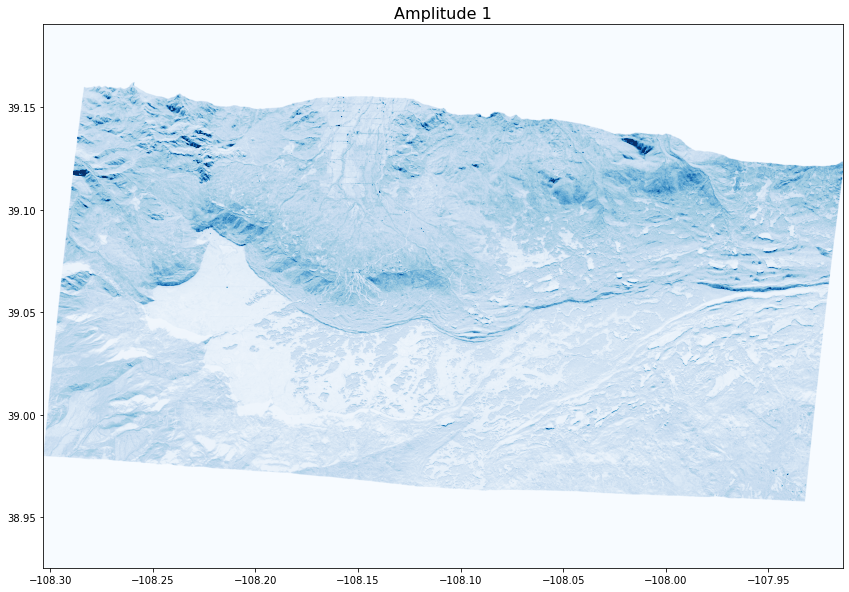

<AxesSubplot:title={'center':'Amplitude 1'}>

In [51]:
amp1_rast = rio.open(amp1) #open raster
fig, ax = plt.subplots(figsize = (10,7)) #define figure size
ax.set_title("Amplitude 1",fontsize = 16); #set title and font size
show((amp1_rast, 1), cmap = 'Blues', vmin = 0, vmax = 1) #plot, set color type and range

## Amp 2

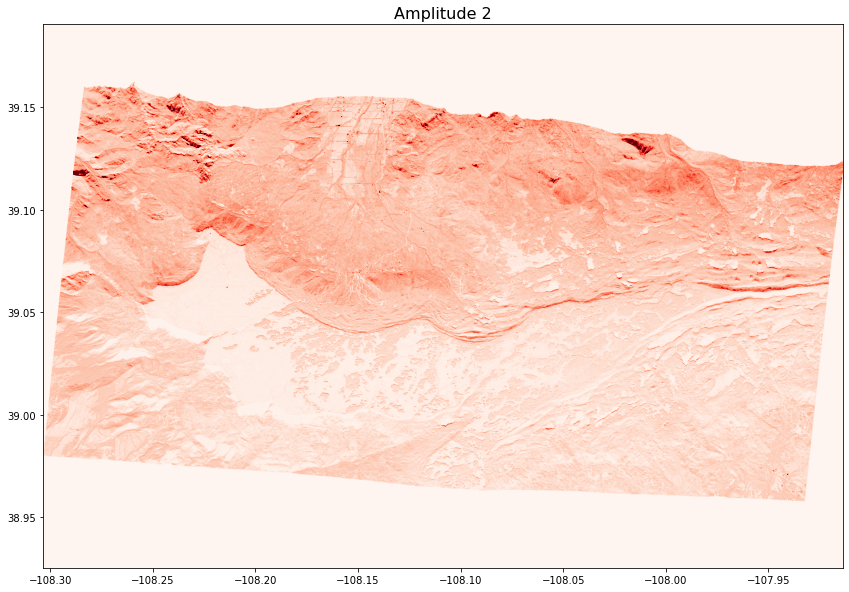

<AxesSubplot:title={'center':'Amplitude 2'}>

In [52]:
amp2_rast = rio.open(amp2)
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Amplitude 2",fontsize = 16);
show((amp2_rast, 1), cmap = 'Reds', vmin = 0, vmax = 1)

## Coherence

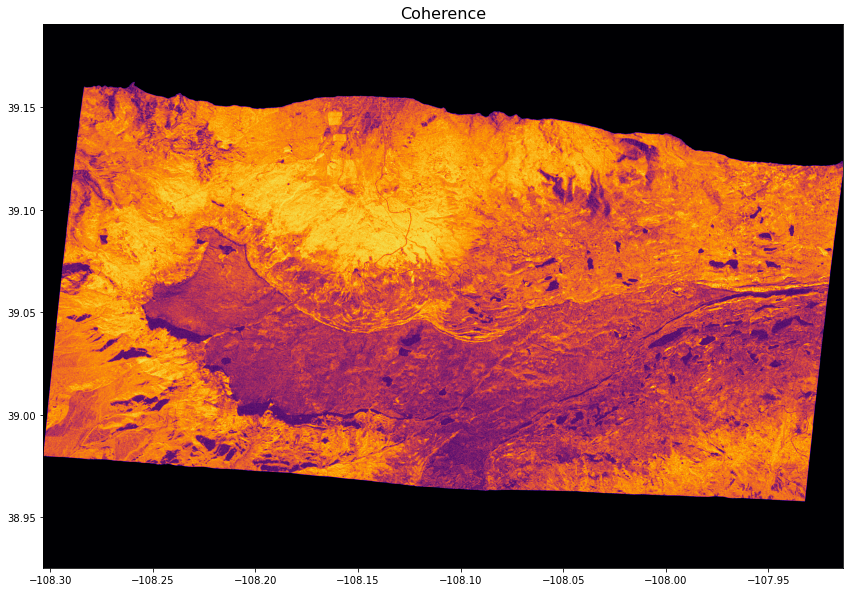

<AxesSubplot:title={'center':'Coherence'}>

In [53]:
cor_rast = rio.open(cor)
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Coherence",fontsize = 16);
show((cor_rast, 1), cmap = 'inferno', vmin = 0, vmax = 1)

## DEM

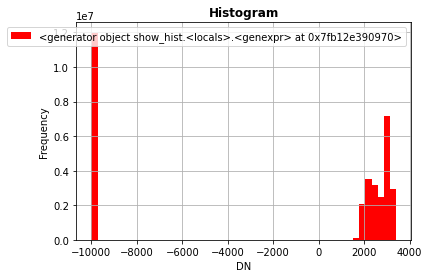

In [57]:
# histogram to check we should set the color scale too
# note the no data value around -10000

dem_rast = rio.open(dem)
show_hist(dem_rast, bins = 50)

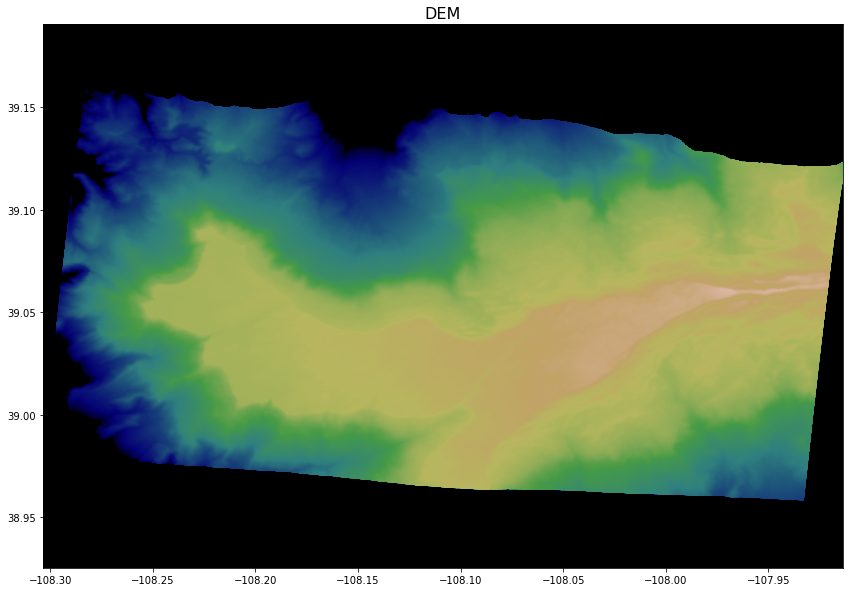

<AxesSubplot:title={'center':'DEM'}>

In [59]:
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("DEM",fontsize = 16);
show((dem_rast, 1), cmap = 'gist_earth', vmin = 1900, vmax = 3600) #estimated these values from the histogram

## Unwrapped Phase

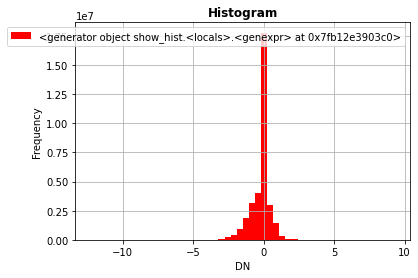

In [61]:
# histogram to figure out color scale boundaries
unw_rast = rio.open(unw)
show_hist(unw_rast, bins = 50)

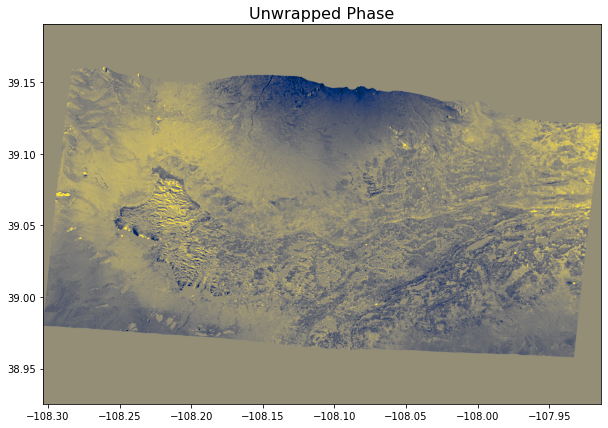

<AxesSubplot:title={'center':'Unwrapped Phase'}>

In [73]:
unw_rast = rio.open(unw)
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Unwrapped Phase",fontsize = 16);
show((unw_rast, 1), cmap = 'cividis', vmin = -3, vmax = 2) # info from histogram

## Formatting the data for visualization
The plots of the raw data need some work. Some fotmatting is necessay to visualize the data clearly. UAVSAR uses "0" as it's no data value (not the best practice in general) for amplitude, coherence, and unwrapped phase. For the DEM -10000 is the no data value. Using -9999 or another value that is obviously not actual data is a better practice with spatial data to limit confusion. We'll convert these no data values to NA which will remove the boarders around data, and allow us to see the 

## Amplitude formatting
For the two amplitude files we need to do two things. Convert from the linear amplitude scale to decibel (dB) and change the 0 values to NAN. To do this we'll convert our raster file to an numpy (np) array to manipulate it.

In [94]:
# amp1 
# open raster as a data array
with rio.open(amp1) as amp1_raw:
    amp1_array = amp1_raw.read(1)

# convert all 0's to nan
amp1_array[amp1_array == 0] = np.nan

# covert to dB
amp1_dB = 10.0 * np.log10(amp1_array)

# amp2 
with rio.open(amp2) as amp2_raw:
    amp2_array = amp2_raw.read(1)
    
amp2_array[amp2_array == 0] = np.nan

amp2_dB = 10.0 * np.log10(amp2_array)

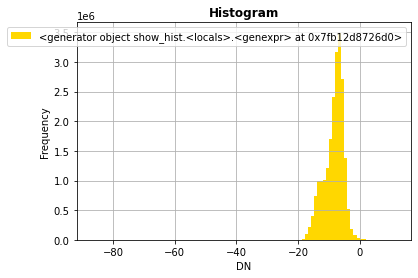

In [95]:
# quick histogram to check what the color scale should be set to
show_hist(amp2_dB, bins = 100)

##
Instead of using the rio.show() function, we'll try out the matplotlib style of plotting to impliment a color bar.

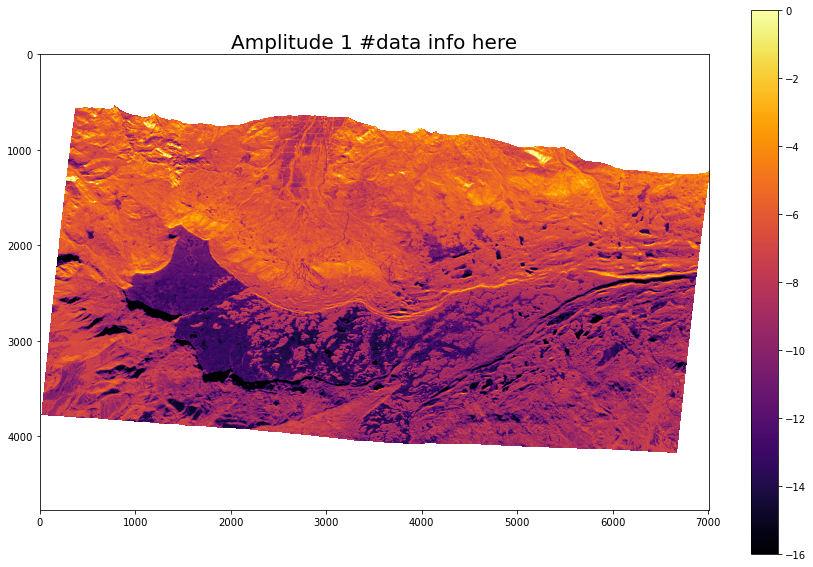

In [98]:
# test matplotlib style of plot bc it has color bar
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Amplitude 1 #data info here", fontsize= 20)
amp2_plot = ax.imshow(amp2_dB, cmap='inferno',vmin=-16, vmax=0)

# add legend
colorbar = fig.colorbar(amp2_plot, ax=ax)
plt.show()

-6.234073638916016


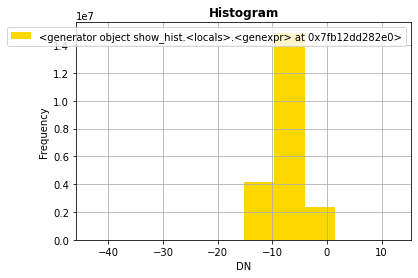

In [109]:
vmax = np.nanpercentile(amp1_dB, 55)
print(vmax)
show_hist(amp1_dB)

In [129]:
# function for showing two images using matplotlib

def show_two_images(img1, img2, col1, col2, vmin=None, vmax=None):

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # auto setting axis limits
    if vmin == None:
        vmin1 = np.nanpercentile(img1, 5)
    if vmax == None:
        vmax1 = np.nanpercentile(img1, 95)
    
    # plot image
    plt1 = ax1.imshow(img1, cmap=col1, vmin=vmin1, vmax=vmax1)
    ax1.set_title("fix title")
    ax1.xaxis.set_label_text('Linear stretch Min={} Max={}'.format(vmin1, vmax1))
        
    # add color scale
    colorbar = fig.colorbar(plt1, ax=ax1, fraction=0.03, pad=0.04)
    
    
     # auto setting axis limits
    if vmin == None:
        vmin2 = np.nanpercentile(img2, 5)
    if vmax == None:
        vmax2 = np.nanpercentile(img2, 95)
    
    # plot image
    plt2 = ax2.imshow(img2, cmap=col2, vmin=vmin2, vmax=vmax2)
    ax2.set_title('fix title')
    ax2.xaxis.set_label_text('Linear stretch Min={} Max={}'.format(vmin2, vmax2))
    colorbar = fig.colorbar(plt2, ax=ax2, fraction=0.03, pad=0.04)
    plt.show()


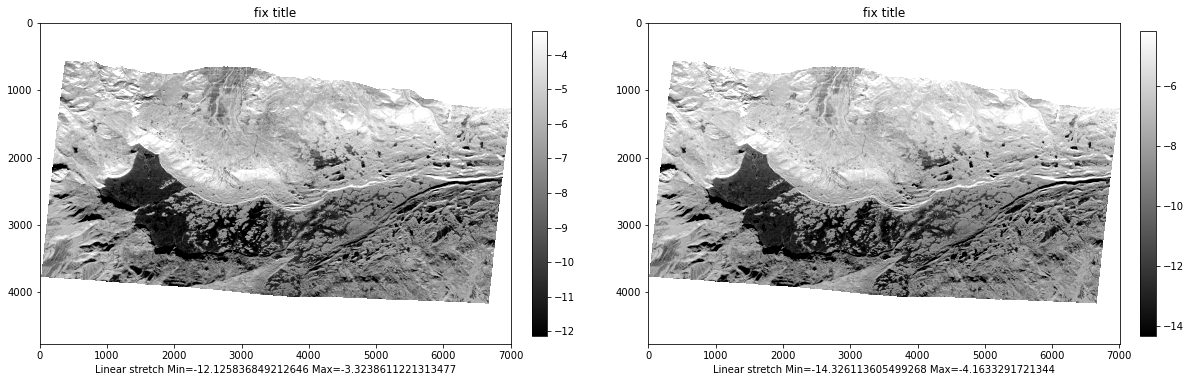

In [132]:
show_two_images(amp1_dB, amp2_dB, 'gray', 'gray')

## Coherence, Unwrapped Phase, DEM
For this data, we only need to convert no data values to NAN

In [121]:
# cor 
# open raster as a data array
with rio.open(cor) as cor_raw:
    cor_array = cor_raw.read(1)

# convert all 0's to nan
cor_array[amp1_array == 0] = np.nan

# unw
with rio.open(unw) as unw_raw:
    unw_array = unw_raw.read(1)
    
unw_array[unw_array == 0.000000] = np.nan

# dem
with rio.open(dem) as dem_raw:
    dem_array = dem_raw.read(1)
    
dem_array[dem_array == -10000] = np.nan

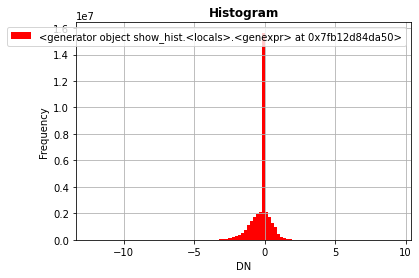

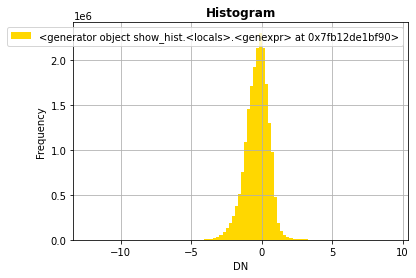

In [136]:
show_hist(unw_rast, bins = 100)
show_hist(unw_array, bins = 100)

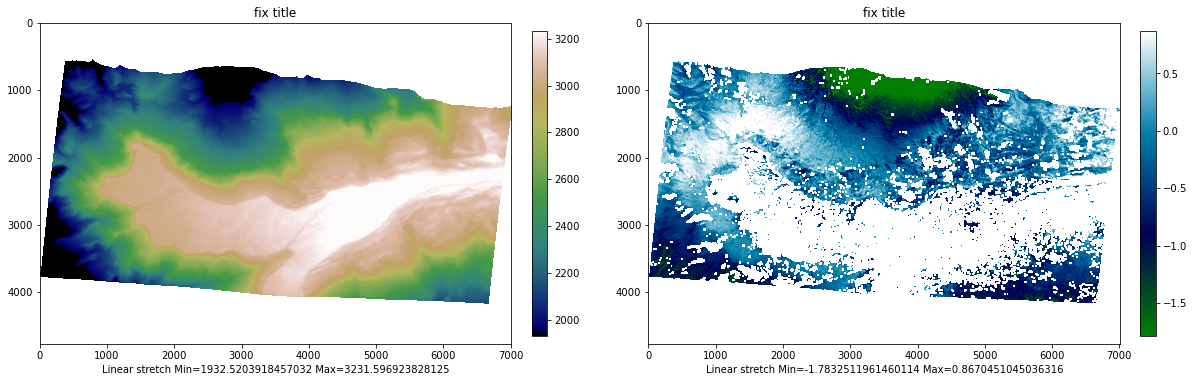

In [133]:
show_two_images(dem_array, unw_array, 'gist_earth', 'ocean')

## Quick facts

| frequency | resolution (rng x azi m) | swath width (km) |
| - | - | - | 
| L-band | 1.8 | 16 | 

Documentation:
* https://uavsar.jpl.nasa.gov/science/documents.html
* https://asf.alaska.edu/data-sets/sar-data-sets/uavsar/

Data Access:

* [NASA Earthdata Suborbital Search](https://search.earthdata.nasa.gov/portal/suborbital/search?fi=UAVSAR&as[instrument][0]=UAVSAR)
* [ASF Vertex SnowEx Grand Mesa Campaign]

`https://search.asf.alaska.edu/#/?dataset=UAVSAR&mission=Grand%20Mesa,%20CO&resultsLoaded=true&granule=UA_grmesa_27416_21019-017_21021-005_0006d_s01_L090_01-AMPLITUDE_GRD&zoom=3&center=-92.747866,10.530273&productTypes=AMPLITUDE_GRD`

## API data access